In [1]:
# hide
# default_exp L2A_user_model_explore.py
# from nbdev.showdoc import *

# 02 User profile churn modeling

> Building user profile and churn modeling + surrogate model + interpreation

## Library

In [2]:
# Library
import pandas as pd
import numpy as np
import os
from zipfile import ZipFile
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns; sns.set_theme()
from collections import defaultdict

from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
import tsfresh

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn import tree
import networkx as nx

In [5]:
import shap
# load JS visualization code to notebook
shap.initjs()

## Functions

In [6]:
#exports
def load_directory_files_dict(dir_path)->dict:
    'Load all pkl files in the directory into dict'
    L1file_list = os.listdir(path_load)
    L1file_list = [i for i in L1file_list if not i.startswith(".")]
    L1name_list = [i.split("_")[0]+"_"+i.split("_")[1].replace(".pkl","") for i in L1file_list]

    dt = {}
    for name, key in zip(L1file_list, L1name_list):
        dt[key] = pd.read_pickle(os.path.join(path_load,name))
    return dt

def add_prefix_columns(dt:pd.DataFrame, columns_ignore:list, prefix:str)->pd.DataFrame:
    'Add prefix for columns to mark its origin'
    dt.columns = [i if i in idx_columns else prefix+i for i in dt.columns]
    return dt

def shorten_columns_str(input_list:list):
    'Cleaner column name for plotting later'
    return [
        i.replace("absolute_sum_of_changes","abs_changes_sum")
        .replace("linear_trend__attr_\"slope\"","linear_slope")
        .replace("year","yr")
        .replace("month","mnt")
        .replace("linear_trend__attr_\"intercept\"","linear_inter")
        .replace("maximum","max")
        .replace("minimum","min")
        .replace("sum_values","sum")
        .replace("benford_correlation","outliers")
        .replace("voice_outgoing", "voice_out")
        .replace("data_download","data_down")
        for i in input_list
    ]



## Data

In [7]:
# data
path_load = os.path.join("Data","L1")
path_save = os.path.join("Data","L2")

dt = load_directory_files_dict(path_load)

## Model preprocessing
- Add prefix to indicate column's origin
- Combine data from various sources into one
- Setup on X, y and train/test for model training

In [8]:
# setup
idx_columns = ['msisdn','planning_area','churn']
dt_list     = ['user_train','user_location','geo_census','geo_school','user_cdr','user_web']
prefix_list = ['train__'   ,'loc__'        ,'census__'  ,'school__'  ,'cdr__'   ,'web__'   ]

# adding prefix to features
for dt_x,prefix_x in zip(dt_list, prefix_list):
    dt[dt_x] = add_prefix_columns(dt=dt[dt_x], columns_ignore=idx_columns, prefix=prefix_x)
    
# combining into a full dataframe
user_profile = (dt['user_train']
#  .merge(dt['user_location'])
 .merge(dt['geo_census'])
 .merge(dt['geo_school'])
 .merge(dt['user_cdr'])
 .merge(dt['user_web'])
)
# note that record with NA are dropped in the preprocessing.
# users_location is too spares for user data with RF, i will be removing it from here.

user_profile.head()

,msisdn,churn,train__age,train__contract,train__internet_service,train__account_start_year,planning_area,train__month_delta,census__med_income,census__avg_income,...,web__starhub__sum_values,web__starhub__mean,web__starhub__absolute_sum_of_changes,web__singtel__absolute_sum_of_changes,"web__starhub__linear_trend__attr_""intercept""","web__singtel__linear_trend__attr_""intercept""",web__singtel__minimum,web__starhub__benford_correlation,web__starhub__minimum,web__singtel__benford_correlation
0,6048764759382,0,44,0,1,2018,TOA PAYOH,25,1500,5089.771035,...,1779.0,296.500000,1213.0,2009.0,133.571429,630.857143,184.0,0.473221,79.0,0.057715
1,891319344217,0,56,1,1,2010,TOA PAYOH,117,1500,5089.771035,...,4656.0,776.000000,2144.0,2499.0,919.714286,244.857143,140.0,-0.026776,310.0,0.383169
2,99251853671,0,26,0,1,2007,TOA PAYOH,151,1500,5089.771035,...,3502.0,583.666667,2862.0,1306.0,444.523810,293.380952,76.0,0.662261,17.0,-0.282165
3,9795194264183,0,48,0,0,2014,TOA PAYOH,73,1500,5089.771035,...,4214.0,702.333333,1985.0,995.0,947.476190,609.190476,176.0,0.055723,440.0,0.077998
4,5833245602906,0,52,0,0,2018,TOA PAYOH,15,1500,5089.771035,...,3069.0,511.500000,1605.0,764.0,237.571429,386.809524,311.0,0.140976,82.0,-0.110172


In [9]:
user_profile.to_pickle((os.path.join(path_save, "user_profile.pkl")))

In [10]:
# cleaning column name
user_profile.columns = shorten_columns_str(user_profile.columns)

# correlation against churn
user_profile_sub = user_profile.copy()
user_profile_sub.drop(['msisdn','planning_area'],axis=1,inplace=True)
user_churn_corr = user_profile_sub.corr()['churn'][1:].sort_values()
user_churn_corr_dt = pd.DataFrame(user_churn_corr).reset_index().rename({'index':'features','churn':'corr'}, axis=1)

# target-y, features-X split
user_profile.drop('planning_area', axis=1, inplace=True)
user_profile_msisdn = user_profile.pop('msisdn')
y = churn = user_profile.pop('churn')
X = user_profile.values
X_columns = user_profile.columns

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7,
    shuffle=True, stratify=y)
# stratified to ensure that we have adequate for churns as 
# the data is imbalanced 90/10.

X.shape

(14824, 37)

## Model - Features Selection
Given that currently we have 60+ columns/features, it is very possible that we can select a subset of features without sacrifing accuracy.

Using Random Forest as a base model here, as it:
- can deal with correlated data 
- outliers resistant
- the class weight can account for class imbalance
- easy to setup
- does not need additional scaling on features
- provide feature_importances

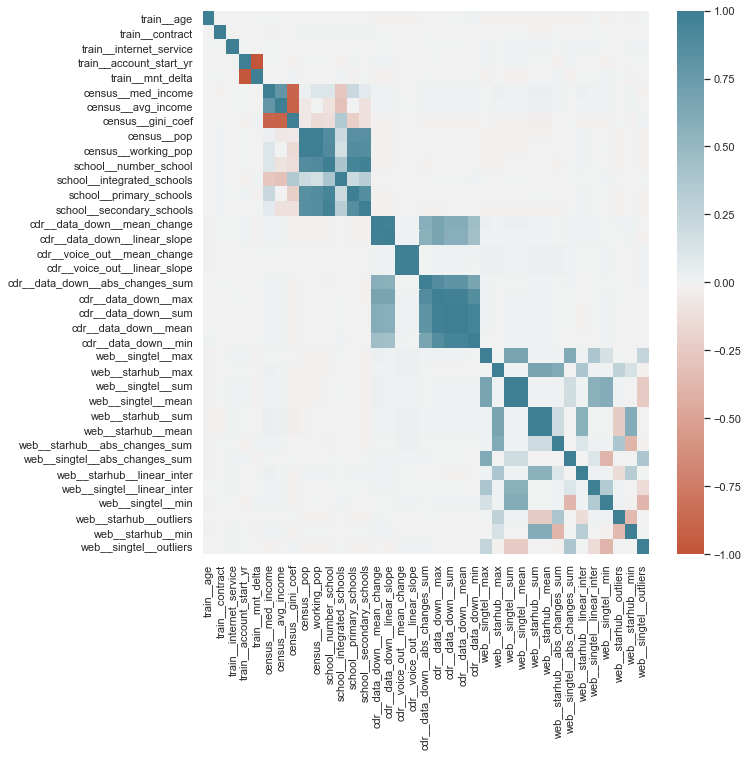

In [11]:
columns_wo_loc= [i for i in user_profile.columns if not i.startswith('loc')]
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(user_profile[columns_wo_loc].corr(),
            annot = False, fmt='.1g',
            vmin=-1, vmax=1, center= 0,
            cmap=sns.diverging_palette(20, 220, n=200),
            ax = ax);

### RF - features_importances
on sklearn, this is proprotional on how many times a features is used for a split, this is sensitive to high cardinitiy hence typically isn't surfficient byitself.

In [12]:
# rf classifier model
parameters = {'n_estimators':[300,500], 
              'max_depth':[4,7], 
              'min_samples_leaf' :[0.05,0.03]
             }
clf = RandomForestClassifier(n_jobs =-1, random_state=0, class_weight='balanced_subsample', bootstrap = True)
clf.fit(X_train, y_train)

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

### permutation_importance
The permutation importance is calculated on the training set to show how much the model relies on each feature during training. In the case of classifier, how does one feature impact on the accuracy

In [13]:
result = permutation_importance(clf, X_train, y_train, n_repeats=20, n_jobs =-1, scoring = 'balanced_accuracy',
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

### visualisation importance

FixedFormatter should only be used together with FixedLocator


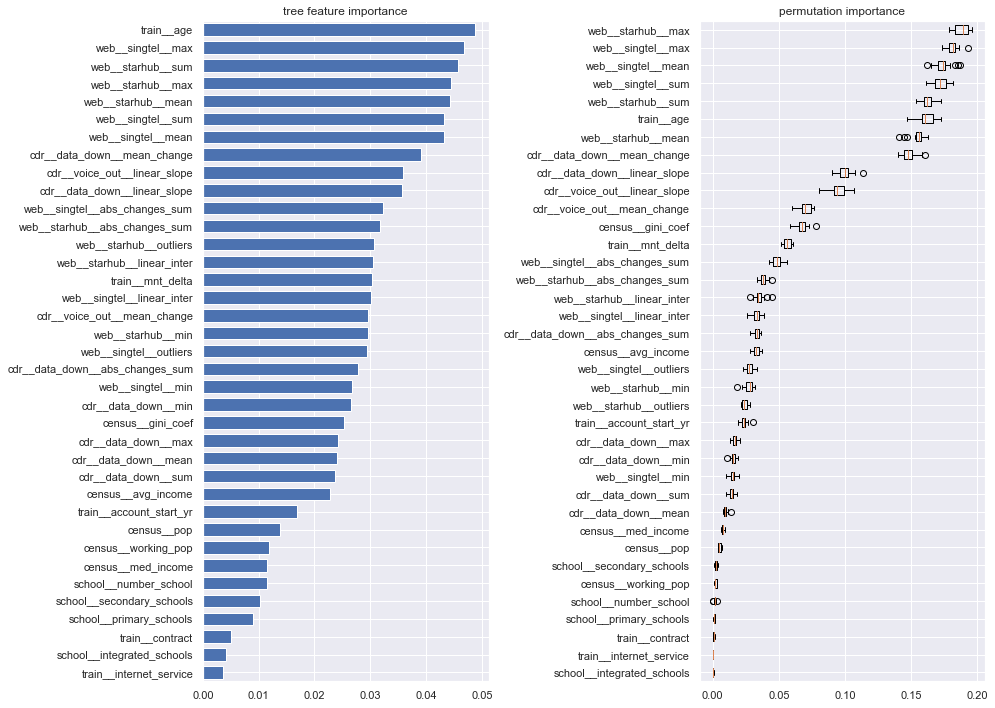

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.title.set_text('tree feature importance')
ax2.title.set_text('permutation importance')
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

### select significant features
based on permutation importance - features that aid in accuracy

In [15]:
# config
threshold = 0.02

# filtering for features
importances_dt = pd.DataFrame([[x,y] for x,y in zip(X_columns, result['importances_mean'])])
importances_dt.columns = ['features','tree importance']
importances_dt.sort_values('tree importance', ascending=False, inplace=True)
features_sel_list = importances_dt.loc[importances_dt['tree importance']>threshold, 'features'].tolist()

In [16]:
# additional selectino on features
X = user_profile[features_sel_list].values
X_columns = user_profile[features_sel_list].columns

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7,
    shuffle=True, stratify=y)

# stratified to ensure that we have adequate data on churns as 
# the data is imbalanced - 90/10.
X.shape

(14824, 23)

## hyperparameter tuning

In [17]:
# gridsearchCV
# using RF as it is resistance to multi collinearity, 
parameters = {'n_estimators':[300,500], 
              'max_depth':[4,7], 
              'min_samples_leaf' :[0.05,0.03]
             }
rf = RandomForestClassifier(n_jobs =-1, random_state=0, class_weight='balanced_subsample', bootstrap = True)
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
clf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                       min_samples_leaf=0.03, n_estimators=500, n_jobs=-1,
                       random_state=0)

### metrics

In [18]:
clf = clf.best_estimator_

y_predict_train = clf.predict(X_train)
y_predict_test = clf.predict(X_test)

print(f'balanced accuracy on train data {balanced_accuracy_score(y_train, y_predict_train)}')
print(f'balanced accuracy on test data {balanced_accuracy_score(y_test, y_predict_test)}')

print(f'accuracy on train data {accuracy_score(y_train, y_predict_train)}')
print(f'accuracy on test data {accuracy_score(y_test, y_predict_test)}')

balanced accuracy on train data 0.6935274016373449
balanced accuracy on test data 0.6816358699044884
accuracy on train data 0.710919230077352
accuracy on test data 0.7023745277927684


In [19]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81      3320
           1       0.21      0.66      0.31       386

    accuracy                           0.70      3706
   macro avg       0.58      0.68      0.56      3706
weighted avg       0.87      0.70      0.76      3706



## graph visual
features - connection visualisation

In [20]:
graph_dt = importances_dt.loc[importances_dt['tree importance']>threshold, :].copy()
graph_dt.loc[:,'origin'] = [i.split('__')[0] for i in graph_dt['features']]
graph_dt.loc[:,'var'] = ['_'.join(i.split('__')[1:]) for i in graph_dt['features']]
graph_comb_dt = graph_dt.merge(user_churn_corr_dt)

In [21]:
graph_comb_dt

,features,tree importance,origin,var,corr
0,web__starhub__max,0.187943,web,starhub_max,0.138823
1,web__singtel__max,0.181137,web,singtel_max,0.147302
2,web__singtel__mean,0.173747,web,singtel_mean,0.143316
3,web__singtel__sum,0.172321,web,singtel_sum,0.143316
4,web__starhub__sum,0.161949,web,starhub_sum,0.139961
5,train__age,0.161884,train,age,-0.115886
6,web__starhub__mean,0.154797,web,starhub_mean,0.139961
7,cdr__data_down__mean_change,0.147947,cdr,data_down_mean_change,0.110994
8,cdr__data_down__linear_slope,0.100130,cdr,data_down_linear_slope,0.111824
9,cdr__voice_out__linear_slope,0.094425,cdr,voice_out_linear_slope,0.095881


to be illustrated with graph (nodes and edges) for variables + grouping

## PDP
partiel dependence plot for trends on single variable

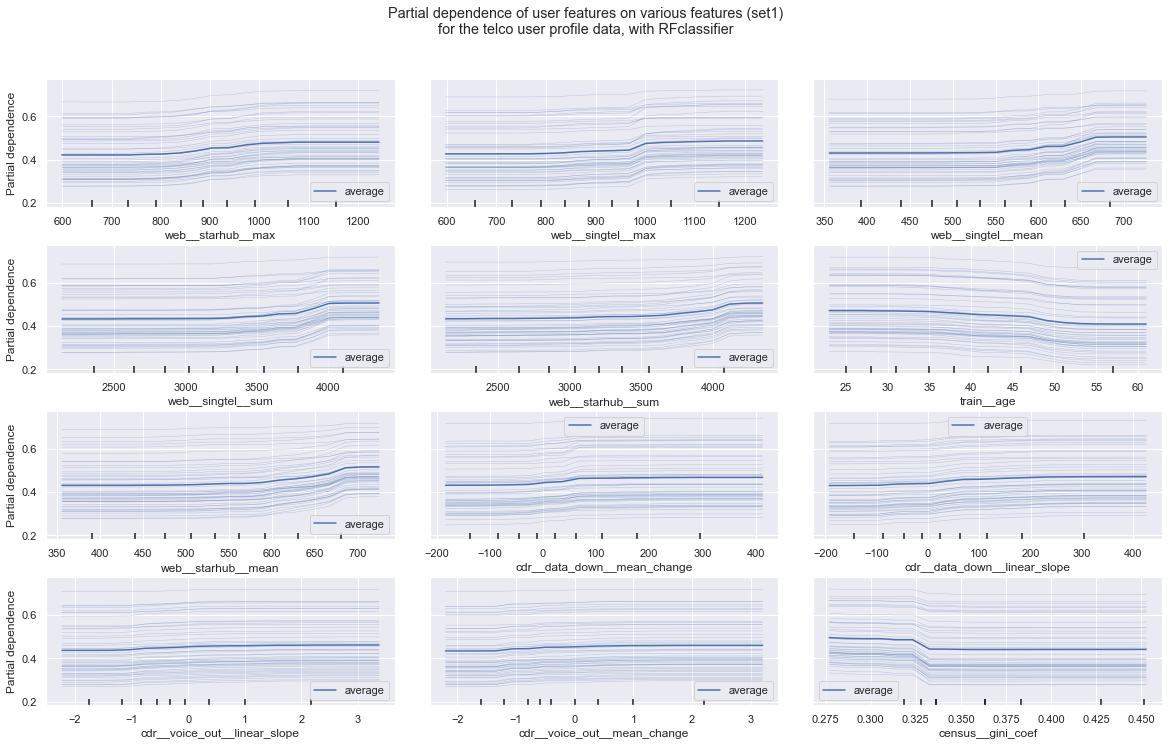

In [22]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.subplots_adjust( bottom=0.01, hspace=0.2, wspace=0.1)
features = list(range(len(X_columns)))[:12]

display = plot_partial_dependence(
    clf, pd.DataFrame(X, columns=X_columns),
    features, kind="both", subsample=50,
    n_jobs=-1, grid_resolution=20, random_state=0,
    ax=ax
)

display.figure_.suptitle(
    'Partial dependence of user features on various features (set1)\n'
    'for the telco user profile data, with RFclassifier'
)
display.figure_.subplots_adjust(hspace=0.3)



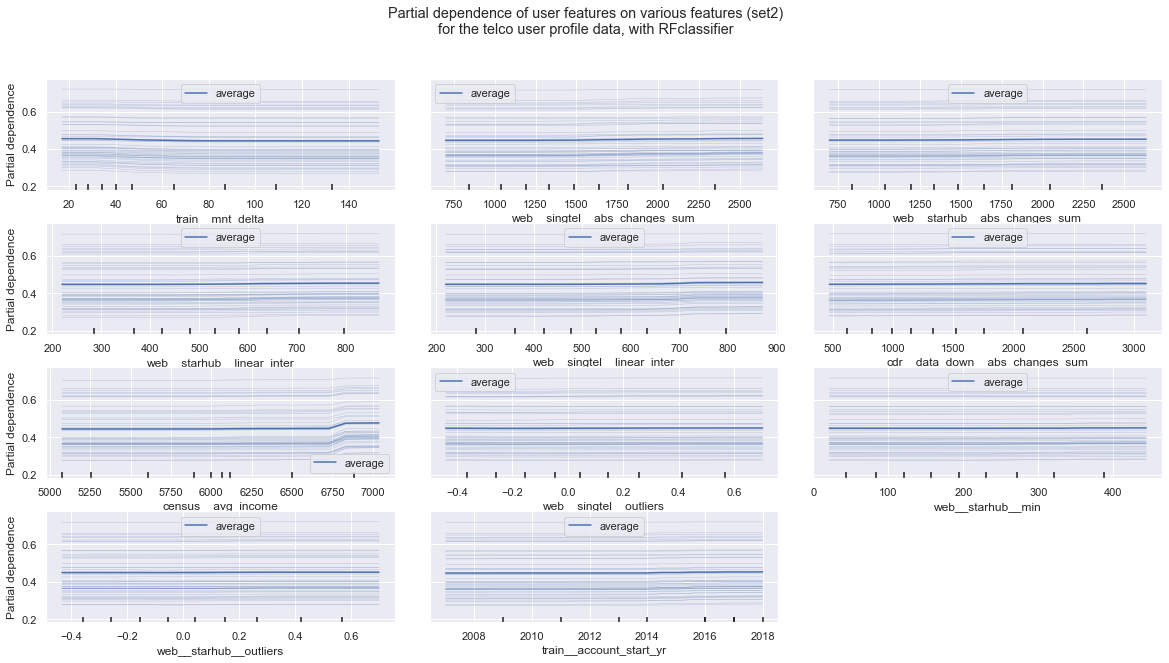

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
features = list(range(len(X_columns)))[12:]

display = plot_partial_dependence(
    clf, pd.DataFrame(X, columns=X_columns),
    features, kind="both", subsample=50,
    n_jobs=-1, grid_resolution=20, random_state=0,
    ax=ax
)

display.figure_.suptitle(
    'Partial dependence of user features on various features (set2)\n'
    'for the telco user profile data, with RFclassifier'
)
display.figure_.subplots_adjust(hspace=0.3)

## Surrogate model - Decision tree

In [24]:
dtree_clf = DecisionTreeClassifier(random_state=0, max_depth=3, class_weight='balanced')
dtree_clf.fit(X_train, y_train)

y_predict_train = dtree_clf.predict(X_train)
y_predict_test = dtree_clf.predict(X_test)

print(f'balanced accuracy on train data {balanced_accuracy_score(y_train, y_predict_train)}')
print(f'balanced accuracy on test data {balanced_accuracy_score(y_test, y_predict_test)}')

print(f'accuracy on train data {accuracy_score(y_train, y_predict_train)}')
print(f'accuracy on test data {accuracy_score(y_test, y_predict_test)}')

balanced accuracy on train data 0.6416168693166964
balanced accuracy on test data 0.6034872651226668
accuracy on train data 0.7910595430832884
accuracy on test data 0.773610361575823


decision tree visualisation

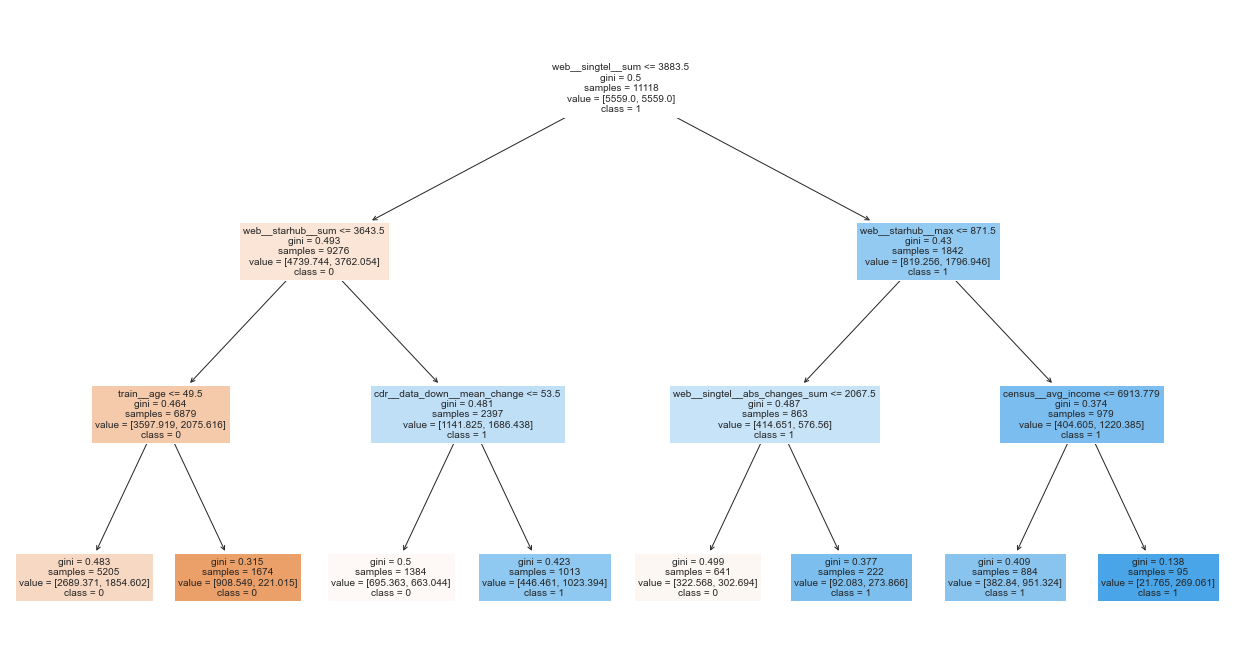

In [25]:
fig = plt.figure(figsize=(22,12))
_ = tree.plot_tree(dtree_clf, 
                   feature_names=X_columns,  
                   class_names=['0', '1'],
                   filled=True,
                   fontsize=10)

## Shap

In [26]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
X_dt = pd.DataFrame(X, columns=X_columns)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_dt, y)

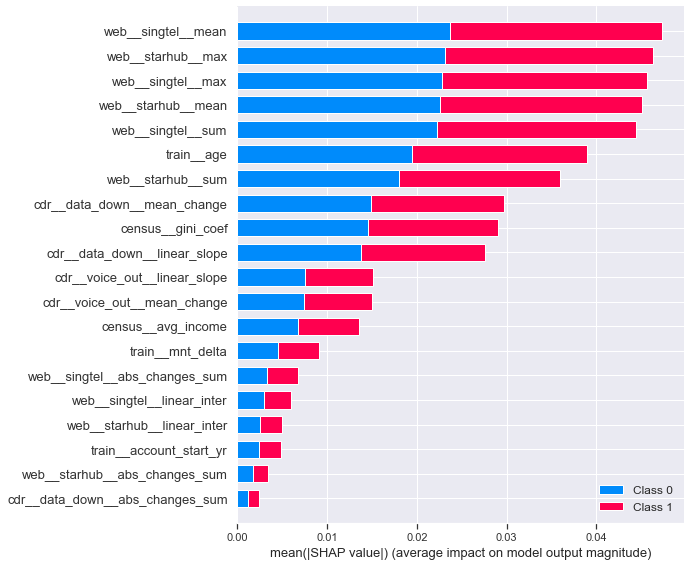

In [27]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_columns)

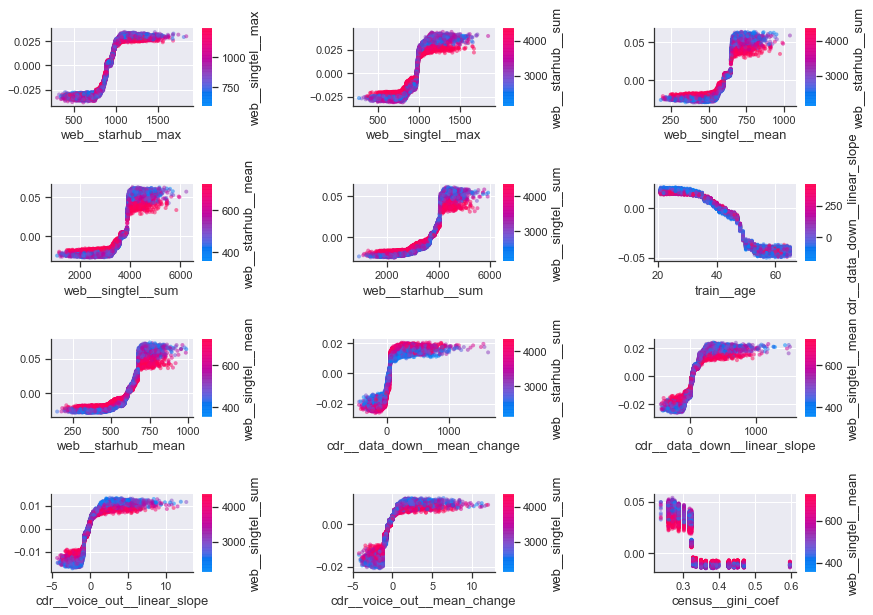

In [28]:
X_dt = pd.DataFrame(X, columns = X_columns)

fig, axs = plt.subplots(4, 3, figsize=(14, 10))
fig.subplots_adjust(hspace=1, wspace=.7)
axs = axs.ravel()

for ax, name in zip(axs, X_columns[:12]):
    shap.dependence_plot(name, shap_values[1], X_dt, display_features=X_dt, ax=ax, show=False, alpha=0.5, );
    ax.set_ylabel("")

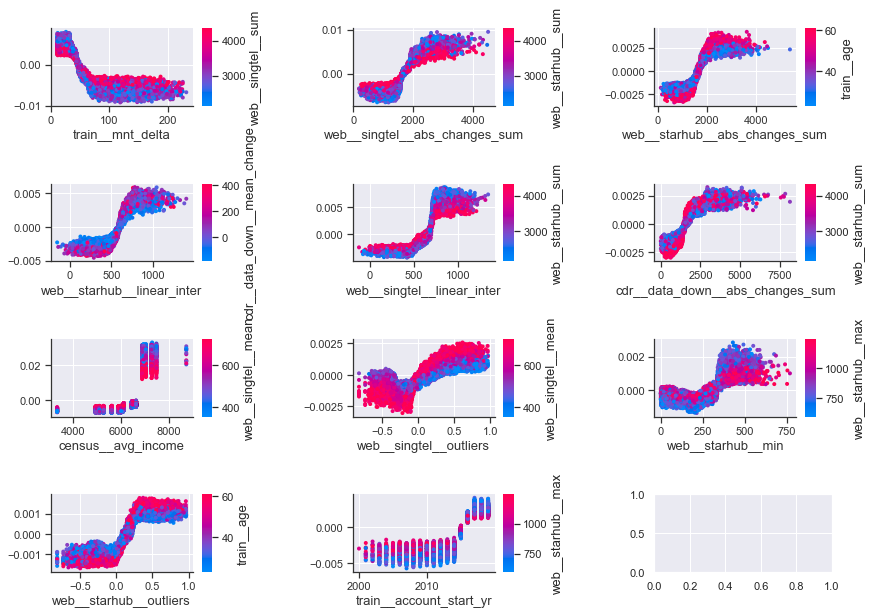

In [29]:
X_dt = pd.DataFrame(X, columns = X_columns)

fig, axs = plt.subplots(4, 3, figsize=(14, 10))
fig.subplots_adjust(hspace=1, wspace=.7)
axs = axs.ravel()

for ax, name in zip(axs, X_columns[12:]):
    shap.dependence_plot(name, shap_values[1], X_dt, display_features= X_dt, ax=ax, show=False);
    ax.set_ylabel("")